In [ ]:
# Import Required Packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

import platform
import time
import pathlib
import os


In [ ]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('NumPy version:', np.__version__)

Python version: 3.10.12
Tensorflow version: 2.15.0
NumPy version: 1.25.2



**Definition of the Dataset**

Dataset can be downloaded from here: https://eightportions.com/datasets/Recipes/.

The dataset consists of approximately 125,000 recipes scraped from various food websites. Each recipe includes several key components that provide a comprehensive guide to preparing a dish. These components are:
*   Title: The name of the recipe, e.g., "Guacamole".
*   Ingredients: A detailed list of all the ingredients required for the recipe, including measurements and specific details about each ingredient.
*   Instructions: Step-by-step directions on how to prepare the dish.

Each recipe is stored in JSON format, with each recipe being a dictionary that includes keys for the title, ingredients, and instructions. Example JSON:


```
{
    "title": "Guacamole",
    "ingredients": [
        "3 Haas avocados, halved, seeded and peeled",
        "1 lime, juiced",
        "1/2 teaspoon kosher salt",
        "1/2 teaspoon ground cumin",
        "1/2 teaspoon cayenne",
        "1/2 medium onion, diced",
        "1/2 jalapeño pepper, seeded and minced",
        "2 Roma tomatoes, seeded and diced",
        "1 tablespoon chopped cilantro",
        "1 clove garlic, minced"
    ],
    "instructions": "In a large bowl place the scooped avocado pulp and lime juice, toss to coat. Drain, and reserve the lime juice, after all of the avocados have been coated. Using a potato masher add the salt, cumin, and cayenne and mash. Then, fold in the onions, tomatoes, cilantro, and garlic. Add 1 tablespoon of the reserved lime juice. Let sit at room temperature for 1 hour and then serve."
}

```




In [ ]:
# Create cache folder.
cache_dir = './tmp/datasets'
pathlib.Path(cache_dir).mkdir(exist_ok=True, parents=True)

In [ ]:
!unzip /content/tmp/datasets/recipes_raw.zip -d /content/tmp/datasets/


Archive:  /content/tmp/datasets/recipes_raw.zip
  inflating: /content/tmp/datasets/recipes_raw_nosource_ar.json  
  inflating: /content/tmp/datasets/recipes_raw_nosource_epi.json  
  inflating: /content/tmp/datasets/recipes_raw_nosource_fn.json  
  inflating: /content/tmp/datasets/LICENSE  


In [ ]:
!ls -la ./tmp/datasets/


total 251968
drwxr-xr-x 2 root root     4096 Jun 16 20:38 .
drwxr-xr-x 3 root root     4096 Jun 16 20:35 ..
-rw-rw-r-- 1 root root    20437 Feb 12  2018 LICENSE
-rw-rw-r-- 1 root root 49784325 Mar 23  2018 recipes_raw_nosource_ar.json
-rw-rw-r-- 1 root root 61133971 Mar 23  2018 recipes_raw_nosource_epi.json
-rw-rw-r-- 1 root root 93702755 Mar 23  2018 recipes_raw_nosource_fn.json
-rw-r--r-- 1 root root 53355492 Jun 16 20:36 recipes_raw.zip


**Visualization of the Dataset Features and Results**

*  Visualise sample of a recipe with the 'title', 'instructions', and 'ingredients' from the data set

In [ ]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]

    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            print(dataset_file_path)
            print('===========================================')
            print('Number of examples: ', len(json_data_list), '\n')
            print('Example object keys:\n', dict_keys, '\n')
            print('Example object:\n', json_data_list[0], '\n')
            print('Required keys:\n')
            print('  title: ', json_data_list[0]['title'], '\n')
            print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
            print('  instructions: ', json_data_list[0]['instructions'])
            print('\n\n')

    return dataset

In [ ]:
# Load dataset
dataset_raw = load_dataset()

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [ ]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


**Cleaning the Text Data**

The following cleaning methos are applied to each recipes:
*  Filter out incomplete recipes:  Recipes that do not have a title, ingredients, or instructions are removed.
*  Convert recipe objects into strings:  Ensure that the title, ingredients, and instructions are all in string format.
*  Remove noisy strings:  Specifically, remove the noisy string "ADVERTISEMENT" from the instructions and ingredients.
*  Structure and Delimitation: Add stop words after title, ingredients, and instructions. This helps the model to distinguish between the title, ingredients, and instructions when learning the recipe structure and when generating new recipes.
*  Limited the number of characters in each recipe to 2000.


In [ ]:
# Filters out recipes which don't have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']

    if not recipe:
        return False

    for required_key in required_keys:
        if not recipe[required_key]:
            return False

        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False

    return True

dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalid recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalid recipes 2226


In [ ]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

# Converts recipe object to string
def recipe_to_string(recipe):

    # Remove the noisy string "ADVERTISEMENT" from the instructions and ingredients.
    noize_string = 'ADVERTISEMENT'

    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')

    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'

    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'

    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [ ]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


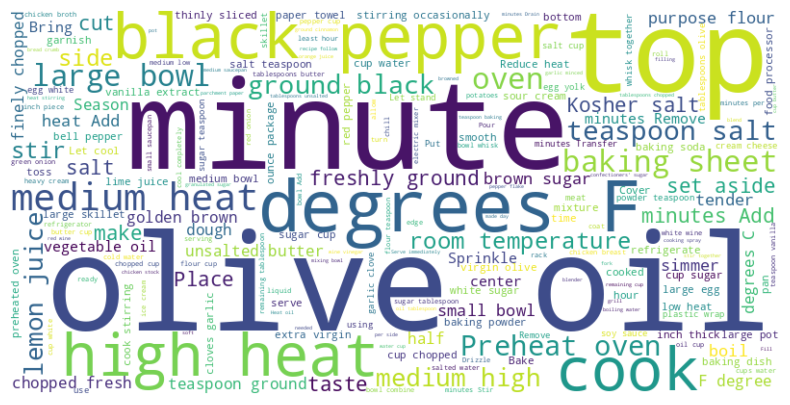

In [ ]:
from wordcloud import WordCloud

# Join the list of strings into a single string
text = ' '.join(dataset_stringified)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

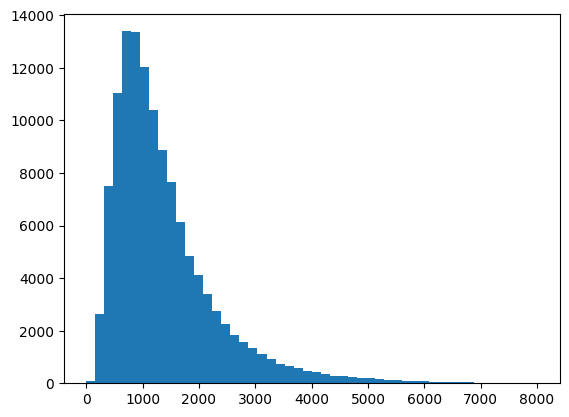

In [ ]:
# Visualize the distribution of the word count
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [ ]:
# Limit of 2000 characters for the recipes will cover more than 80% cases.
MAX_RECIPE_LENGTH = 2000
def filter_recipes_by_length(recipe):
    return len(recipe) <= MAX_RECIPE_LENGTH

In [ ]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of etiminated recipes:  22726


In [ ]:
TOTAL_RECIPES_NUM = len(dataset_filtered)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

TOTAL_RECIPES_NUM:  100212


In [ ]:
# Visualize 5 recipies after preprocessing
for recipe_index, recipe_string in enumerate(dataset_filtered[:5]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

**Creating vocabulary**

In [ ]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.fit_on_texts(dataset_filtered)
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100213,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 100212, " ": 17527888, "S": 270259, "l": 3815150, "o": 5987496, "w": 964459, "C": 222831, "k": 890982, "e": 9296022, "r": 4760887, "h": 2922100, "i": 4911812, "c": 2883507, "n": 5304396, "a": 6067157, "d": 3099679, "D": 63999, "u": 2717050, "m": 1794411, "p": 2679164, "g": 1698670, "s": 4704222, "\\n": 1955281, "\\ud83e\\udd55": 100212, "\\u2022": 922813, "4": 232607, ",": 1130487, "b": 1394803, "t": 5997722, "v": 746785, "2": 493933, "(": 144985, "1": 853931, "0": 145119, ".": 1052548, "7": 31098, "5": 154071, ")": 144977, "f": 1042981, "y": 666553, "\\ud83d\\udcdd": 100212, "\\u25aa": 331058, "\\ufe0e": 331058, "P": 200597, "6": 51398, "H": 43936, "A": 134274, "3": 213519, "R": 101253, "x": 201286, "/": 345257, "I": 81591, "L": 46138, "8": 55352, "9": 17697, "B": 123813, "M": 78684, "F": 104359, "j": 1

In [ ]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


**Vectorizing the dataset**


In [ ]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100212


In [ ]:
# Display the vector representing the maximum length recipe
max_index_example = max(dataset_vectorized, key=len)
print('max_index_example: ', max_index_example)

max_index_example:  [51, 1, 45, 14, 22, 22, 3, 10, 5, 13, 12, 2, 22, 68, 9, 1, 33, 4, 8, 3, 23, 19, 2, 8, 8, 28, 1, 50, 12, 14, 19, 3, 8, 19, 1, 39, 7, 2, 16, 16, 52, 16, 16, 24, 1, 26, 30, 29, 1, 13, 14, 15, 1, 23, 12, 7, 4, 2, 1, 9, 14, 18, 3, 8, 1, 16, 24, 1, 26, 30, 29, 1, 13, 14, 15, 1, 3, 10, 10, 36, 15, 14, 8, 15, 5, 9, 2, 1, 22, 10, 5, 14, 8, 1, 16, 24, 1, 26, 1, 4, 2, 3, 9, 15, 5, 5, 6, 1, 18, 8, 5, 14, 6, 11, 1, 13, 7, 6, 6, 3, 17, 5, 6, 1, 16, 24, 1, 26, 30, 34, 1, 13, 14, 15, 1, 13, 12, 7, 10, 10, 2, 11, 1, 19, 14, 4, 4, 2, 8, 1, 16, 24, 1, 26, 1, 8, 2, 13, 7, 15, 2, 1, 15, 3, 9, 4, 8, 28, 1, 22, 5, 8, 1, 3, 1, 71, 36, 7, 6, 13, 12, 1, 11, 5, 14, 19, 10, 2, 1, 13, 8, 14, 9, 4, 1, 15, 7, 2, 1, 16, 24, 1, 26, 1, 15, 7, 6, 4, 1, 22, 8, 2, 9, 12, 1, 9, 4, 8, 3, 23, 19, 2, 8, 8, 7, 2, 9, 20, 1, 9, 10, 7, 13, 2, 11, 1, 16, 24, 1, 37, 30, 34, 1, 15, 5, 14, 6, 11, 1, 8, 12, 14, 19, 3, 8, 19, 20, 1, 13, 12, 5, 15, 15, 2, 11, 1, 16, 24, 1, 26, 1, 26, 30, 37, 1, 13, 14, 15, 9, 1, 23, 

In [ ]:
# Verify the conversion of vectors back to strings
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])


📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



**Apply padding**
-  This ensures that all sequences are appropriately sized for further processing, likely in a sequence-to-sequence model where X and Y sequences are generated based on these padded sequences.

In [ ]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [ ]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)


In [ ]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)


In [ ]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:5]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001


In [ ]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

**Create tensorflow dataset**

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


In [ ]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

**Split examples on input and target texts**

In [ ]:
# For each sequence, duplicate and shift it to form the input and target text.
# For example, say sequence_length is 4 and our text is Hello. The input sequence would be Hell, and the target sequence ello.
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]

    return input_text, target_text
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [ ]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()

    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]

    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


**Split up the dataset into batches**

In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000
TRAIN_TEST_SPLIT = 0.8


In [ ]:
# Step 1: Split the dataset into training and testing sets
dataset_size = len(list(dataset_targeted))
train_size = int(TRAIN_TEST_SPLIT * dataset_size)
test_size = dataset_size - train_size

dataset_train = dataset_targeted.take(train_size)
dataset_test = dataset_targeted.skip(train_size)

dataset_train = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

# Print to verify
print("Training Dataset:", dataset_train)
print("Testing Dataset:", dataset_test)


Training Dataset: <_RepeatDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>
Testing Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>


In [ ]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  75 ... 165 165 165]
 [ 51   1  45 ... 165 165 165]
 [ 51   1  54 ... 165 165 165]
 ...
 [ 51   1  61 ... 165 165 165]
 [ 51   1  33 ... 165 165 165]
 [ 51   1  39 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  75   3 ... 165 165 165]
 [  1  45   8 ... 165 165 165]
 [  1  54   8 ... 165 165 165]
 ...
 [  1  61   8 ... 165 165 165]
 [  1  33  10 ... 165 165 165]
 [  1  39  14 ... 165 165 165]], shape=(64, 2000), dtype=int32)


In [ ]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

**Build the model**

tf.keras.Sequential is used to define the model with following layers:

*  tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with 256 dimensions;

*  tf.keras.layers.GRU: A type of RNN with size units=1024

*  tf.keras.layers.Dense: The output layer, with VOCABULARY_SIZE

In [ ]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))
    model.add(tf.keras.layers.GRU(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    return model


In [ ]:

model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           45056     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 176)           180400    
                                                                 
Total params: 4163760 (15.88 MB)
Trainable params: 4163760 (15.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


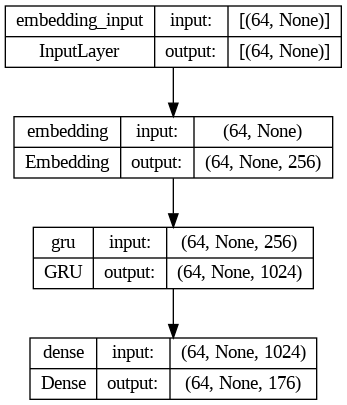

In [ ]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

In [ ]:
# Loss function.
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    return entropy

**Util methods to gerenrate text and plot learning curve**

In [ ]:
def render_training_history(training_history):
    # Extract the history
    history_dict = training_history.history

    # Plotting the learning curves
    plt.figure(figsize=(12, 8))

    # Plot training & validation loss values
    plt.subplot(2, 1, 1)
    plt.plot(history_dict['loss'], label='Training Loss')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


In [ ]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model):
    recipe_length = 2000
    try_letters = ['', 'A', 'C', 'L', 'Mushroom', 'Apple', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4]


    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

**Model-1 : LSTM with Adam optimizer**
*  Accuracy:
*  Loss:

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(
    optimizer=adam_optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
EPOCHS = 7
STEPS_PER_EPOCH = 1500

history_1 = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
         early_stopping_callback,
         checkpoint_callback
    ]
)

Epoch 1/7
1500/1500 [==============================] - 409s 270ms/step - loss: 0.6087 - accuracy: 0.8327
Epoch 2/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.3260 - accuracy: 0.9003
Epoch 3/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.3013 - accuracy: 0.9068
Epoch 4/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.2893 - accuracy: 0.9099
Epoch 5/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.2767 - accuracy: 0.9134
Epoch 6/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.2495 - accuracy: 0.9214
Epoch 7/7
1500/1500 [==============================] - 411s 274ms/step - loss: 0.2463 - accuracy: 0.9224


In [ ]:
# Evaluate the model on the test dataset
test_loss_1, test_accuracy_1 = model_1.evaluate(dataset_test)

print(f"Test Loss GRU-Adam Optimizer:  {test_loss_1}")
print(f"Test Accuracy LSTM-Adam Optimizer: {test_accuracy_1}")

313/313 [==============================] - 31s 95ms/step - loss: 0.3637 - accuracy: 0.8909
Test Loss LSTM-Adam Optimizer:  0.36367857456207275
Test Accuracy LSTM-Adam Optimizer: 0.8909372091293335


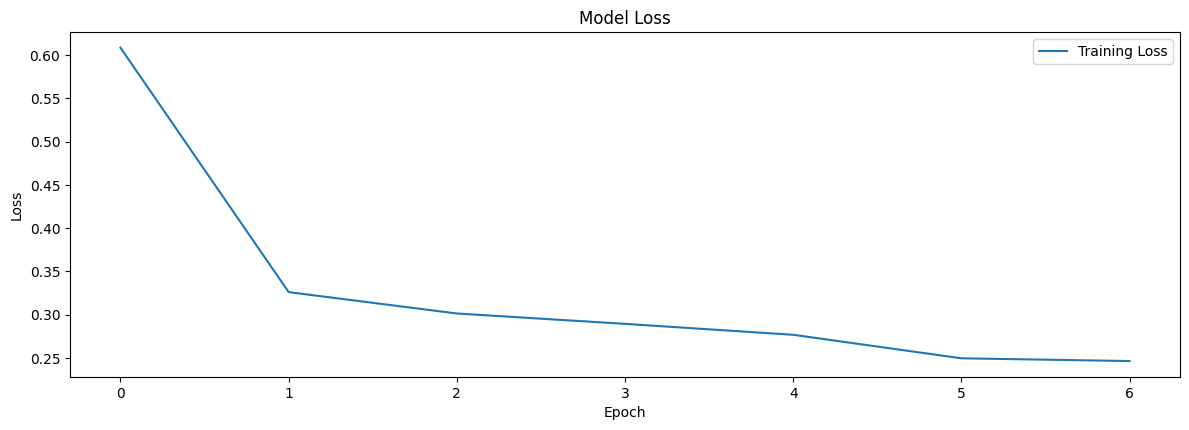

In [ ]:
render_training_history(history_1)


In [ ]:
simplified_batch_size = 1

model_1_lstm_Adam = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_lstm_Adam.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_lstm_Adam.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
generate_combinations(model_1_lstm_Adam)

Attempt: "" + 1.0
-----------------------------------
📗 Dash cher fruit salad ingredients concentrating.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

**Model-2 : GRU with Nadam**

Accuracy: 88.92%


In [ ]:
model_2 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           45056     
                                                                 
 gru_1 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_1 (Dense)             (64, None, 176)           180400    
                                                                 
Total params: 4163760 (15.88 MB)
Trainable params: 4163760 (15.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model_2.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 7
STEPS_PER_EPOCH = 1500

history_2 = model_2.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
         early_stopping_callback,
         checkpoint_callback
    ]
)

Epoch 1/7
1500/1500 [==============================] - 417s 275ms/step - loss: 0.7211 - accuracy: 0.8017
Epoch 2/7
1500/1500 [==============================] - 415s 277ms/step - loss: 0.3362 - accuracy: 0.8979
Epoch 3/7
1500/1500 [==============================] - 415s 276ms/step - loss: 0.3104 - accuracy: 0.9043
Epoch 4/7
1500/1500 [==============================] - 415s 277ms/step - loss: 0.2954 - accuracy: 0.9082
Epoch 5/7
1500/1500 [==============================] - 415s 277ms/step - loss: 0.2808 - accuracy: 0.9123
Epoch 6/7
1500/1500 [==============================] - 415s 276ms/step - loss: 0.2518 - accuracy: 0.9208
Epoch 7/7
1500/1500 [==============================] - 415s 277ms/step - loss: 0.2477 - accuracy: 0.9220


In [ ]:
# Evaluate the model on the test dataset
test_loss_2, test_accuracy_2 = model_2.evaluate(dataset_test)

print(f"Test Loss GRU-NADAM Optimizer:  {test_loss_2}")
print(f"Test Accuracy GRU-NADAM Optimizer: {test_accuracy_2}")

313/313 [==============================] - 30s 93ms/step - loss: 0.3685 - accuracy: 0.8892
Test Loss GRU-NADAM Optimizer:  0.36850571632385254
Test Accuracy GRU-NADAM Optimizer: 0.8892481327056885


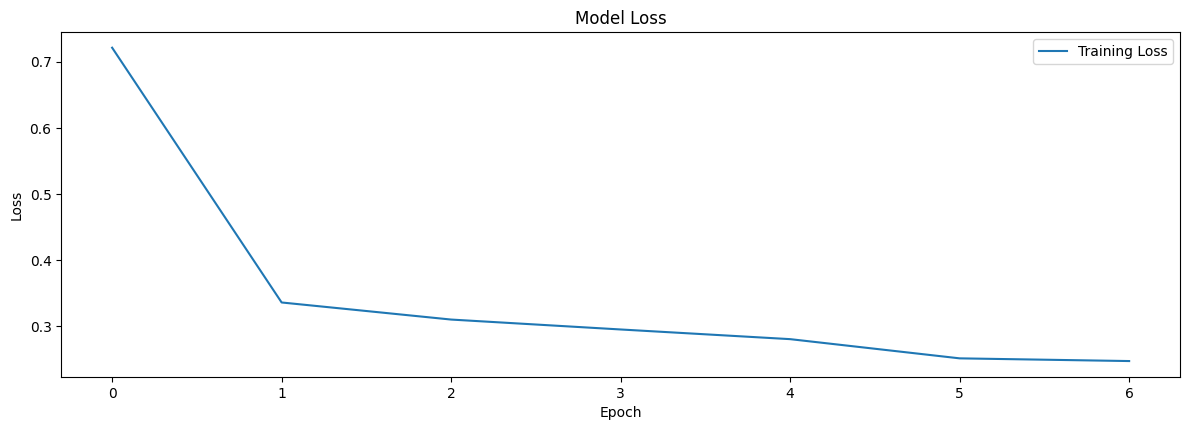

In [ ]:
render_training_history(history_2)

In [ ]:
simplified_batch_size = 1

model_2_lstm_RMSProp = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_2_lstm_RMSProp.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_2_lstm_RMSProp.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
generate_combinations(model_2_lstm_RMSProp)

Attempt: "" + 1.0
-----------------------------------
📗 1 cup pestoppin, chocolate 
• 15 tablespoons butter 
• 1 quart oil for frying (20 chocolate wafers (water* or turnip dish pears total) 
• 2 (15 ounce) cans mold tortilla in
• 7 ounces wheat flour 
• 1 teaspoon vanilla extract 
• 1 1/4 cups white sugar 
• 1 cup packed brown sugar 
• 2/3 cup confectioners' sugar 
• 8 ounces cream cheese, softened 
• 3/4 cup miniature jelly (reduced-fat cake) 
• 3 pints chocolate chips, candy discarded and room Tempeh

📝

▪︎ Preheat oven to 350 degrees F (175 degrees C). Line a 12x9x2 19-19x99 baking cups.
▪︎ Place walnuts in a 9x13-inch casserole dish and let cool completely.
▪︎ Make crust turns completely any bowl of dry ingredients arrange watermelon cheese mixture, frosting onto the prepared baking sheet. Approximately 1 pack for y mini glasses.
▪︎ Mix cornstarch and white sugar until light and fluffy; beat in eggs and flour. Stir flour into the butter mixture; pour into prepared butter-flavored 